## **환경 설정**
Jupyter notebook을 사용하여 Global-Local CLIP을 작동하기 위해서는 본인의 환경에서 **[설치 가이드](https://github.com/Seonghoon-Yu/Zero-shot-RIS#installation)** 대로 환경을 설정합니다.

<!-- 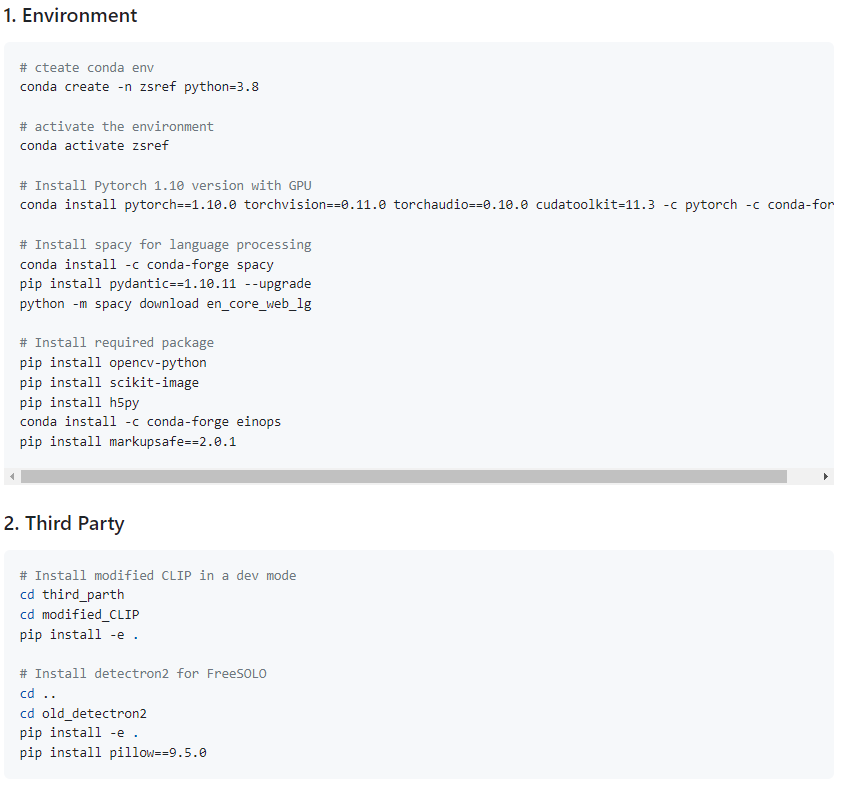 -->

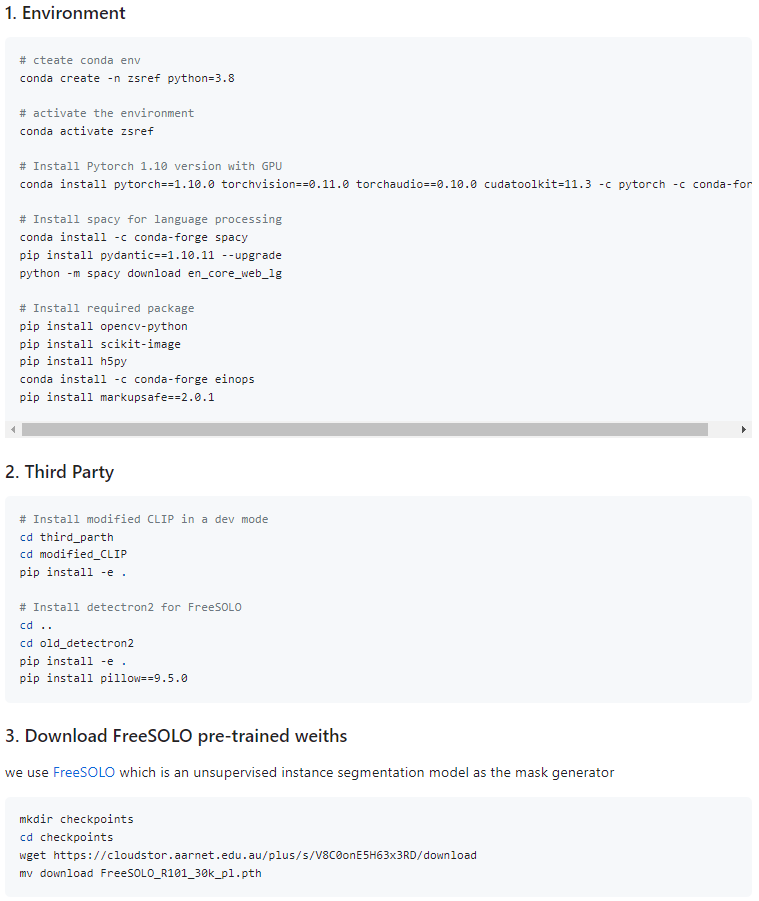

## 설정

In [446]:
# 시각화 코드
import numpy as np
import matplotlib.pyplot as plt

def show_masks(anns):
    if type(anns) ==  torch.Tensor:
        if len(anns.shape) == 2:
            anns = anns.unsqueeze(0)
        anns = anns.cpu().numpy() # Tensor를 cpu로 옮기고 numpy로 변환
    else:
        anns = anns[None,:,:]
    if len(anns) == 0:
        return

    h,w = anns.shape[-2:]
    
    ax = plt.gca() # 현재의 axis 가져오기
    ax.set_autoscale_on(False)

    # sorted_anns = sorted(anns, key=lambda x: -np.sum(x)) # mask size 오름차순으로 정렬

    img = np.ones((h, w, 4)) # 빈 이미지 생성
    img[:,:,3] = 0
    for ann in anns:
        color_mask = np.concatenate([np.random.random(3), [0.7]]) # 마스크 랜덤 색상 지정 및 투명도 설명
        img[ann] = color_mask # 빈 이미지에 마스크 그려넣기
    ax.imshow(img)

## **예시 이미지**

In [654]:
from PIL import Image

img_id = '80472'
path2dir = './example_image' # 이미지 저장 디렉토리

img_name = f'img_{img_id}.jpg' # 이미지 파일 이름
path2img = os.path.join(path2dir, img_name) # 이미지 경로 지정
image = Image.open(path2img).convert("RGB") # 이미지 불러오기

mask_name = f'mask_{img_id}.png' # 마스크 파일 이름
path2mask = os.path.join(path2dir, mask_name) # 마스크 경로 지정
mask = Image.open(path2mask) # 마스크 불러오기
mask = np.array(mask).astype('bool') # 타입 변경

sentence = 'a man with brown hair in a dark green shirt'

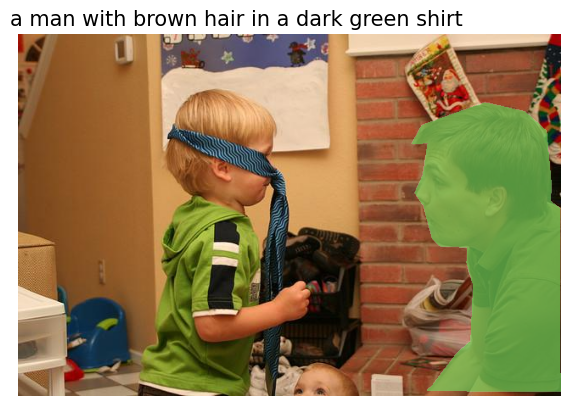

In [655]:
# 마스크 시각화
plt.figure(figsize=(7,7))
plt.imshow(image)
show_masks(mask)
plt.axis('off')
plt.text(-10,-10,sentence, fontsize=15)
plt.show() 

# **FreeSOLO 마스크 생성**


FreeSOLO는 CVPR2022에 개제된 unsupervised instance segmentation 모델입니다.
FreeSOLO를 불러오고 이미지로부터 마스크를 생성합니다.

1. FreeSOLO 불러옵니다.
2. 이미지를 FreeSOLO의 입력값에 맞도록 설정합니다.
3. FreeSOLO의 prediction masks가져옵니다.
4. FreeSOLO의 masks를 시각화 해봅니다.

<img src="attachment:2071b6e9-073f-4a27-ac37-a535089b41ca.png" alt="Image Title" style="width:300px; height:400px;">
.

### **1. FreeSOLO 불러오기**

In [656]:
import argparse
from utils import default_argument_parser, setup

# FreeSOLO
from detectron2.checkpoint import DetectionCheckpointer
from freesolo.engine.trainer import BaselineTrainer
import freesolo.data.datasets.builtin
from freesolo.modeling.solov2 import PseudoSOLOv2

FreeSOLO's config file 과 argment 불러옵니다.

In [14]:
args = default_argument_parser().parse_args(args=[])
cfg = setup(args)
device = 'cuda'

WARNING [08/03 02:47:35 d2.config.compat]: Config 'configs/freesolo/freesolo_30k.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[08/03 02:47:35 detectron2]: Rank of current process: 0. World size: 1
[08/03 02:47:36 detectron2]: Environment info:
----------------------  ----------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.17 (default, Jul  5 2023, 21:04:15) [GCC 11.2.0]
numpy                   1.24.3
detectron2              0.6 @/home/ubuntu/seonghoon/zsref/third_party/old_detectron2/detectron2
Compiler                GCC 9.4
CUDA compiler           CUDA 11.2
detectron2 arch flags   8.0
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.10.0 @/home/ubuntu/miniconda3/envs/zsref/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0,1,2,3             A100-SXM4-40GB (arch=8.0)
Driver version          450.216.04
CUDA_HOME            

Detectron2의 모듈을 사용하여 FreeSOLO를 불러오고, pre-trained 가중치 또한 불러옵니다.

In [17]:
Trainer = BaselineTrainer
Free_SOLO = Trainer.build_model(cfg) # detectron의 Trainer Class를 사용하여 모델 불러오기
Free_SOLO.eval() # evaluation 모드로 전환

path2weights = './checkpoints/FreeSOLO_R101_30k_pl.pth' # pre-trained weights 경로 지정
DetectionCheckpointer(Free_SOLO).resume_or_load(path2weights, resume=True) # pre-trained weights 불러오기


[08/03 02:53:35 d2.engine.defaults]: Model:
PseudoSOLOv2(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2):

{'optimizer': {'state': {0: {'momentum_buffer': tensor([[[[-5.3481e-04]],
    
             [[-2.6929e-04]],
    
             [[-1.6549e-04]],
    
             ...,
    
             [[-6.9877e-05]],
    
             [[-5.1275e-04]],
    
             [[-2.3584e-04]]],
    
    
            [[[-4.5387e-05]],
    
             [[ 1.6206e-04]],
    
             [[ 1.7727e-04]],
    
             ...,
    
             [[ 1.4512e-04]],
    
             [[-1.3591e-04]],
    
             [[ 1.5736e-05]]],
    
    
            [[[ 9.1290e-05]],
    
             [[-1.6876e-05]],
    
             [[-1.2771e-05]],
    
             ...,
    
             [[-1.4094e-04]],
    
             [[ 1.6570e-04]],
    
             [[-6.1770e-05]]],
    
    
            ...,
    
    
            [[[-4.0334e-04]],
    
             [[-7.3950e-06]],
    
             [[-2.1162e-04]],
    
             ...,
    
             [[-4.2783e-06]],
    
             [[-2.9942e-04]],
    
             [

### **2. 이미지를 FreeSOLO의 입력값으로 변환하기**

In [25]:
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

FreeSOLO는 짧은 부분이 800 크기인 이미지를 입력받습니다.

이미지를 resize 하고, tensor로 변한하고, normalize를 진행하겠습니다.

In [657]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] # normalize를 위한 평균, 표준편차 값 지정
width, height = image.size # 이미지의 넓이와 높이 정보 저장

transform = T.Compose([T.Resize(800), # Image 크기 조정
                      T.ToTensor(), # Tensor로 변환
                      T.Normalize(mean, std) # Normalize
                      ])

resized_img = transform(image).unsqueeze(0)

input_img = dict(image=resized_img, height=height, width=width) # dictionary 형태로 변경

### **3. FreeSOLO의 prediction mask 가져오기**

FreeSOLO를 Inference하고 output mask를 가져옵니다.

In [658]:
pred = Free_SOLO([input_img])[0] # FreeSOLO inference
pred_masks = pred['instances'].pred_masks # output mask
pred_boxes = pred['instances'].pred_boxes # output boxes

print(pred_masks.shape)

torch.Size([76, 427, 640])


하나의 이미지로부터 47개의 Masks를 생성했습니다.

### **4. FreeSOLO Mask 시각화 하기**

FreeSOLO는 Unsupervised model 이기 때문에 Mask quality가 낮습니다.

저희는 Zero-shot 컨셉에 맞게 dataset bias가 없는 unsupervised segmentation model인 FreeSOLO 사용하기로 했습니다.

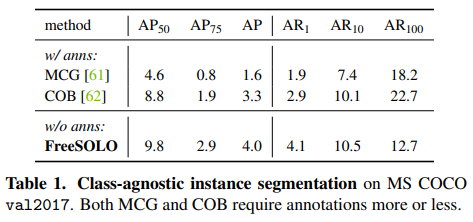

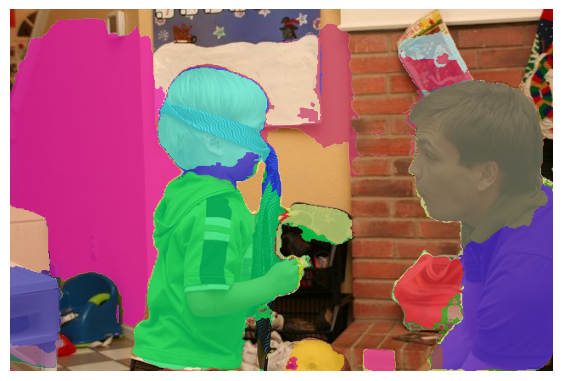

In [659]:
plt.figure(figsize=(7,7))
plt.imshow(image)
show_masks(pred_masks)
plt.axis('off')
plt.show() 

# **Global-Local CLIP 작동하기**

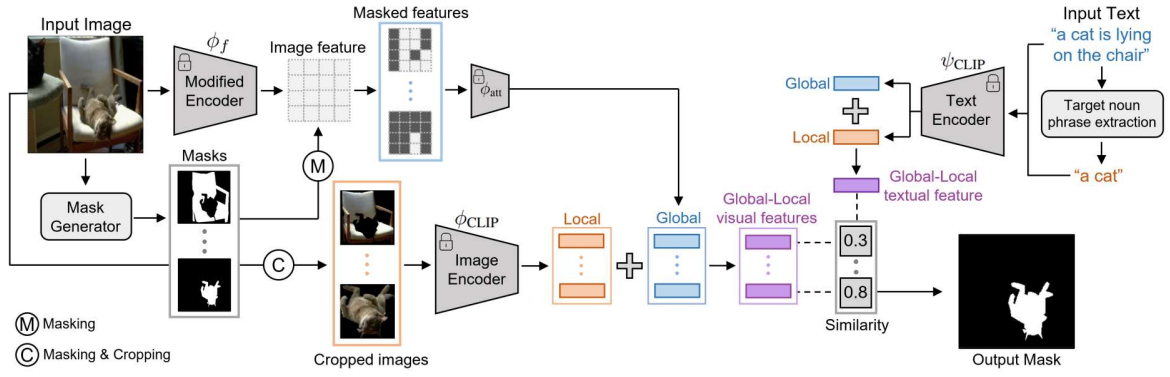

FreeSOLO로 생성한 Masks 를 사용하여 Global-Local CLIP을 작동하겠습니다.

Visual 도메인에서

1. Global context visual features 추출하기
2. Local context visual features 추출하기
3. Global-Local context visual features 추출하기

Textual 도메인에서

4. Global context textual feature 추출하기
5. Local context textual feature 추출하기
6. Global-Local context textual feature 추출하기

마지막으로,

7. 추출한 visual, textual feature를 사용하여 Mask Prediction.

### **1. Global context visual feature 추출하기**

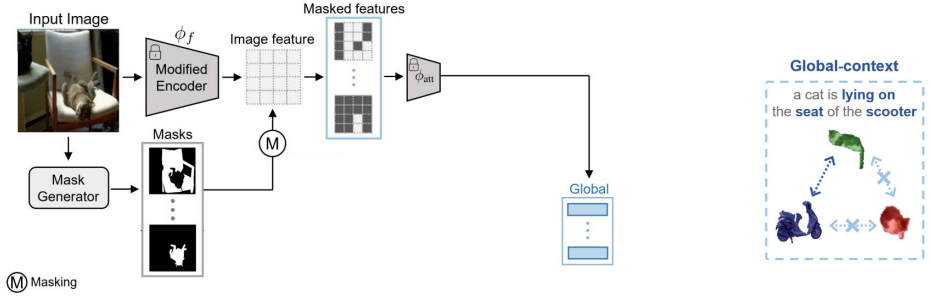


Image를 CLIP의 입력 크기 (224 x 224)로 변환하고, \
CLIP을 불러옵니다.

In [660]:
import clip

transform = T.Resize((224,224))
input_img = transform(resized_img.to(device))

clip_model, _ = clip.load('RN50')

CLIP의 feature map을 가져옵니다.

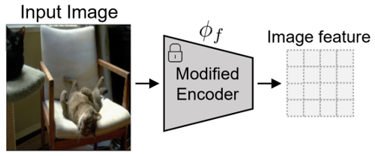

In [661]:
feature_map = clip_model.encode_image(input_img)
feature_map = feature_map / feature_map.norm(dim=1, keepdim=True) # normalize feature map
print(feature_map.shape)

torch.Size([1, 2048, 7, 7])


FreeSOLO의 masks와 feature map을 활용하여 Masked features를 생성합니다.

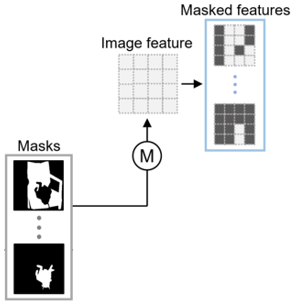

feature map과 masks 들을 element-wise product 하여 masked feature map을 얻습니다.

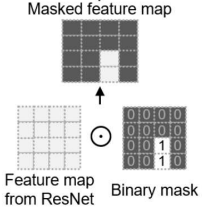

In [662]:
masks = TF.resize(pred_masks.type(torch.float32), (feature_map.shape[2:])) # masks 들을 feature map 크기로 resize 합니다.
masked_feature_map = torch.mul(feature_map, masks[:,None,:,:]) # feature map과 masks 들을 element-wise product 합니다.
print(masked_features.shape)

torch.Size([47, 1024])


Masked feature map을 CLIP의 attention pooling에 입력합니다.

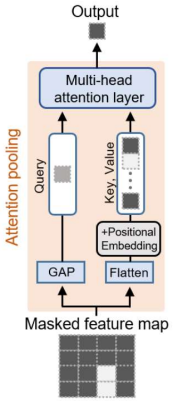

In [663]:
global_visual_features = clip_model.visual.attnpool(masked_feature_map)
print(global_visual_features.shape)

torch.Size([76, 1024])


Global context visual features 는 feature map에 masking을 하여 feature를 추출했으므로 mask 영역뿐만 아니라 image의 넓은 정보가 인코딩 되어있습니다.

저희는 Global context visual features에 object 사이의 관게 정보가 포함되어 있다고 생각했습니다.

하지만 RIS task는 target object를 찾아야 하는 것이 목표이므로 Local context visual features가 핵심적인 역할을 합니다.


### **2. Local context visual features 추출하기**

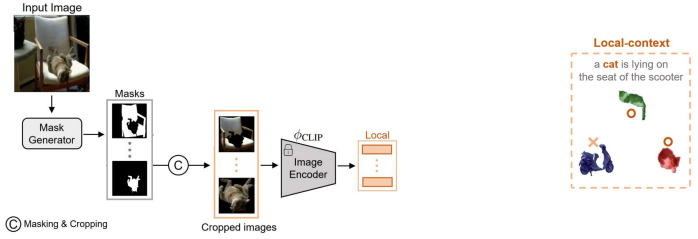

우선, mask를 사용하여 image를 masking하고 crop을 합니다.

In [664]:
pixel_mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1).to(device) # masked 영역을 mean으로 채웁니다.

original_img = T.Resize((height, width))(resized_img).to(device) # 이미지를 원본 크기로 변환

cropped_imgs = []

for m, b in zip(pred_masks, pred_boxes):
    m, b = m.type(torch.uint8), b.type(torch.int) # type 변환
    masked_img = original_img * m[None, None, ...] + (1 - m[None, None, ...]) * pixel_mean

    x_min, y_min, x_max, y_max = b
    h, w = y_max - y_min, x_max - x_min

    cropped_img = TF.resized_crop(masked_img.squeeze(0), y_min, x_min, h, w, (224, 224))
    cropped_imgs.append(cropped_img)

cropped_imgs = torch.stack(cropped_imgs, dim=0)
print(cropped_imgs.shape)

torch.Size([76, 3, 224, 224])


cropped images에는 이미지의 context가 없는 mask 영역의 정보만 포함하고 있습니다.

이 cropped images를 CLIP의 visual encoder에 전달하여 Local context visual features를 추출합니다.

In [665]:
feature_map = clip_model.encode_image(cropped_imgs)
local_visual_features = clip_model.visual.attnpool(feature_map)

local_visual_features = local_visual_features / local_visual_features.norm(dim=1, keepdim=True) # normalize

print(local_visual_features.shape)

torch.Size([76, 1024])


Global 과 Local context visual features의 차이는 masking을 적용한 위치입니다.

masking을 어느 위치에 적용하냐에 따라 feature에 context 정보를 조절할 수 있습니다.

Local context visual features 는 mask 영역만의 feature를 담고 있습니다.

이는 target object에 집중합니다.

### **3. Global-Local context visual features**

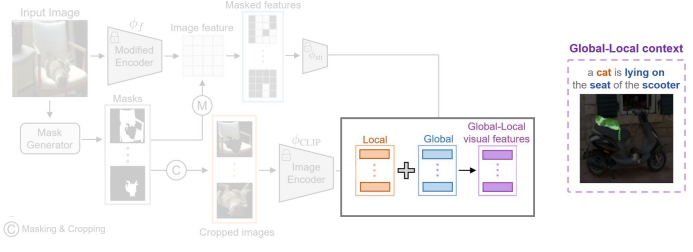

Global context, Local context visual features를 조합하여 Global-Local context visual feautres를 생성합니다.

Global-Local context visual features는 target object 뿐만 아니라 object 사이의 관계를 포착합니다.

0.85는 실험적으로 찾은 값 입니다.

In [666]:
global_local_visual_features = 0.85 * global_visual_features + (1 - 0.85) * local_visual_features
print(global_local_visual_features.shape)

torch.Size([76, 1024])


## **4. Global context textual feature 추출하기**

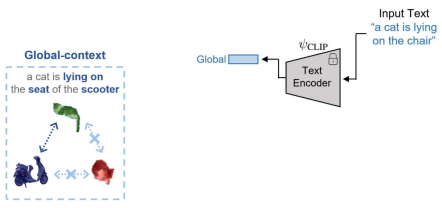

Input text를 CLIP의 text encoder로 전달하여 global context textual feature 를 얻습니다.

Global context textual feature 에는 문장의 전체 맥락이 인코딩 되어 있습니다. 

In [667]:
print('Input Text:', sentence)

Input Text: a man with brown hair in a dark green shirt


In [668]:
from clip.simple_tokenizer import SimpleTokenizer

sentence_token = clip.tokenize(sentence).to(device) # Tokenize

sentence_feature = clip_model.encode_text(sentence_token)
sentence_feature = sentence_feature / sentence_feature.norm(dim=1, keepdim=True)

print(sentence_feature.shape)

torch.Size([1, 1024])


Global context textual feature는 target object에 집중을 못한다는 문제점이 존재합니다.

### **5. Local context textual feature 추출하기**

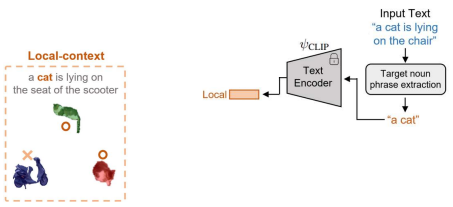

Input text에서 noun phrase를 추출하여 CLIP의 text encoder로 전달합니다.

noun phrase는 dependency parsing tool 인 spacy를 사용하여 추출합니다.

Local context textual feature는 우리가 찾아야하는 target object를 나타내는 noun phrase 로부터 얻으므로 target object에 집중합니다.

In [669]:
import spacy
nlp = spacy.load('en_core_web_lg') # dependency parsing tool

In [670]:
doc = nlp(sentence)
print('sentence: ', sentence)

# 문장에서 noun phrase 찾기
chunks = {}
for chunk in doc.noun_chunks: # dependency parsing으로 찾은 noun phrase를 하나하나 꺼내오기
    for i in range(chunk.start, chunk.end): # 문장에서 각 word가 어느 noun phrase에 속하지 확인 
        chunks[i] = chunk

print('noun phrase 모음: ',chunks)


# root word 찾기
for token in doc:
    if token.head.i == token.i:
        root_word = token.head
        
print('root word: ', root_word)


# root word가 속해있는 noun phrase 추출
noun_phrase = chunks[head.i].text
print('root word가 포함되어 있는 noun phrase: ',noun_phrase)

sentence:  a man with brown hair in a dark green shirt
noun phrase 모음:  {0: a man, 1: a man, 3: brown hair, 4: brown hair, 6: a dark green shirt, 7: a dark green shirt, 8: a dark green shirt, 9: a dark green shirt}
root word:  man
root word가 포함되어 있는 noun phrase:  a man


추출한 noun phrase를 CLIP의 text encoder로 전달합니다.

In [671]:
noun_phrase_token = clip.tokenize(noun_phrase).to(device) # Tokenize

noun_phrase_feature = clip_model.encode_text(noun_phrase_token)
noun_phrase_feature = noun_phrase_feature / noun_phrase_feature.norm(dim=1, keepdim=True) # normalize

print(noun_phrase_feature.shape)

torch.Size([1, 1024])


### **6. Global-Local context textual feature**

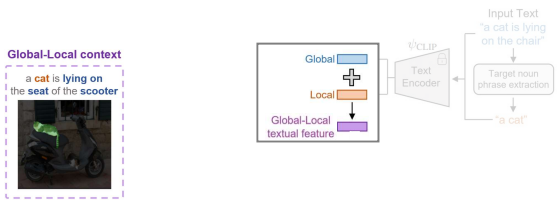

Sentence feature와 noun phrase feautre를 조합하여 Global-Local context textual feature를 얻습니다.

In [672]:
global_local_textual_feature = 0.5 * sentence_feature + (1 - 0.5) * noun_phrase_feature
print(global_local_textual_feature.shape)

torch.Size([1, 1024])


### **7. Mask Prediction**

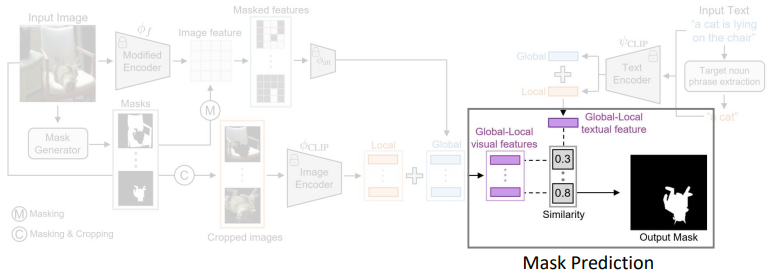

각 마스크에 대한 visual feature와 input text의 text feature 사이의 cosine similarity 를 계산하여, 가장 score가 높은 mask를 선택합니다.

In [673]:
similarity = global_local_visual_features @ global_local_textual_feature.T

max_index = torch.argmax(similarity)

mask_prediction = pred_masks[max_index]

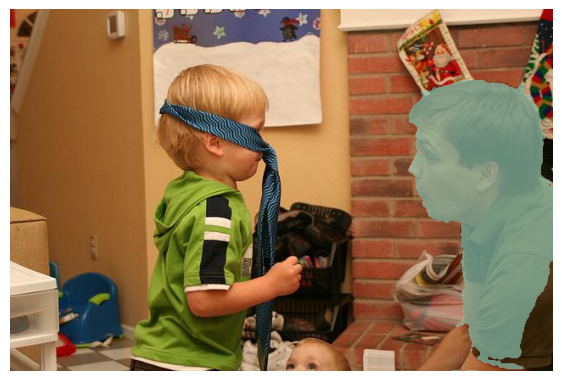

In [674]:
plt.figure(figsize=(7,7))
plt.imshow(image)
show_masks(mask_prediction)
plt.axis('off')
plt.text(-10, -10, sentence, fontsize=15)
plt.show() 

# **서로 다른 context feature를 사용하여 prediction 비교해보기**

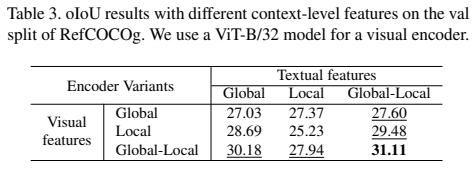


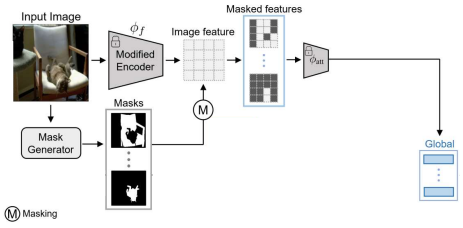  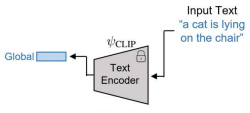

In [675]:
similarity = global_visual_features @ sentence_feature.T

max_index = torch.argmax(similarity)

mask_prediction = pred_masks[max_index]

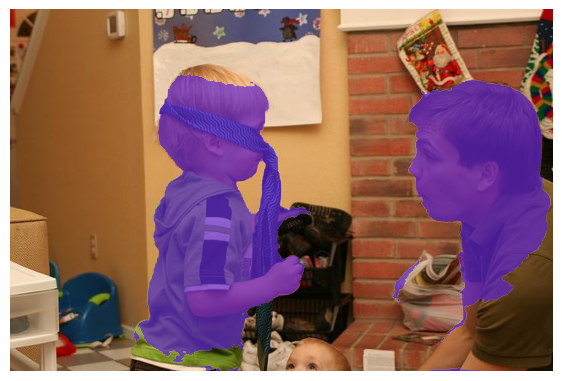

In [676]:
plt.figure(figsize=(7,7))
plt.imshow(image)
show_masks(mask_prediction)
plt.axis('off')
plt.text(-10, -10, sentence, fontsize=15)
plt.show() 

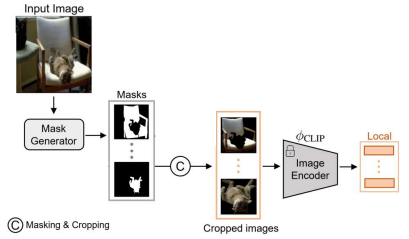  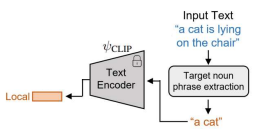

In [677]:
similarity = local_visual_features @ noun_phrase_feature.T

max_index = torch.argmax(similarity)

mask_prediction = pred_masks[max_index]

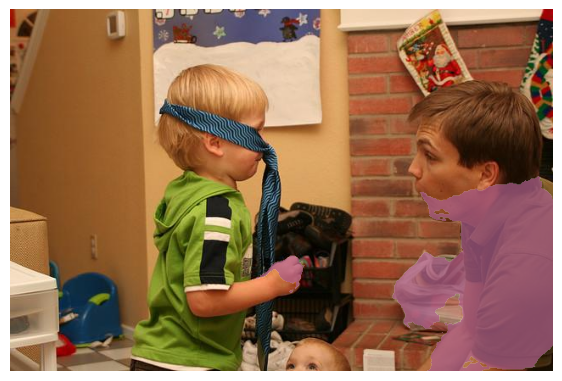

In [678]:
plt.figure(figsize=(7,7))
plt.imshow(image)
show_masks(mask_prediction)
plt.axis('off')
plt.text(-10, -10, noun_phrase, fontsize=15)
plt.show() 

# **다른 예시 이미지**

### **Image, Mask를 불러오고 시각화**

In [682]:
img_id = '44266'
path2dir = './example_image' # 이미지 저장 디렉토리

img_name = f'img_{img_id}.jpg' # 이미지 파일 이름
path2img = os.path.join(path2dir, img_name) # 이미지 경로 지정
image = Image.open(path2img).convert("RGB") # 이미지 불러오기

mask_name = f'mask_{img_id}.png' # 마스크 파일 이름
path2mask = os.path.join(path2dir, mask_name) # 마스크 경로 지정
mask = Image.open(path2mask) # 마스크 불러오기
mask = np.array(mask).astype('bool') # 타입 변경

sentence = 'a brown wicker chair sitting in front of a brown desk'

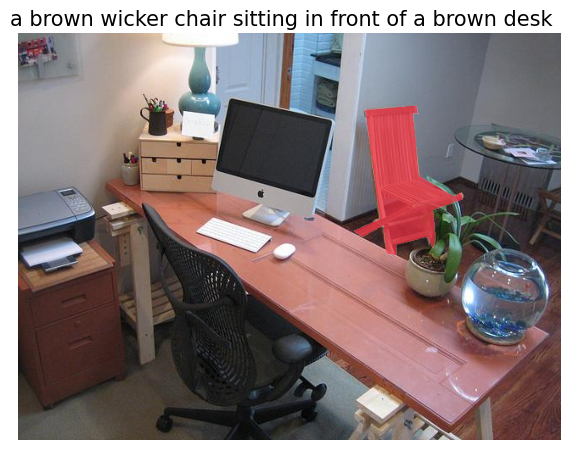

In [683]:
# 마스크 시각화
plt.figure(figsize=(7,7))
plt.imshow(image)
show_masks(mask)
plt.axis('off')
plt.text(-10,-10,sentence, fontsize=15)
plt.show() 

## **FreeSOLO Inference 및 Mask 시각화**

In [684]:
width, height = image.size # 이미지의 넓이와 높이 정보 저장

transform = T.Compose([T.Resize(800), # Image 크기 조정
                      T.ToTensor(), # Tensor로 변환
                      T.Normalize(mean, std) # Normalize
                      ])

resized_img = transform(image).unsqueeze(0)

input_img = dict(image=resized_img, height=height, width=width) # dictionary 형태로 변경

pred = Free_SOLO([input_img])[0] # FreeSOLO inference
pred_masks = pred['instances'].pred_masks # output mask
pred_boxes = pred['instances'].pred_boxes # output boxes

print(pred_masks.shape)

torch.Size([59, 480, 640])


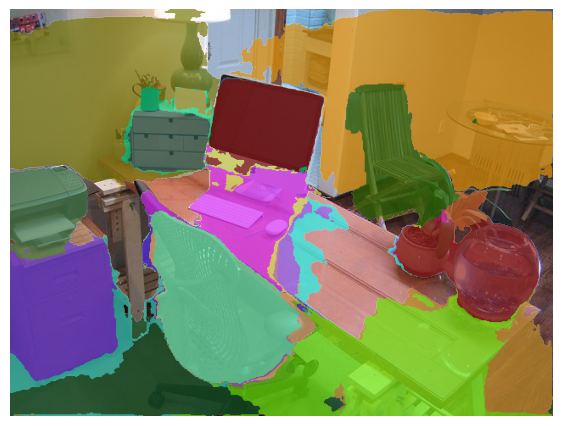

In [685]:
plt.figure(figsize=(7,7))
plt.imshow(image)
show_masks(pred_masks)
plt.axis('off')
plt.show() 

## **Global-Local CLIP 작동**

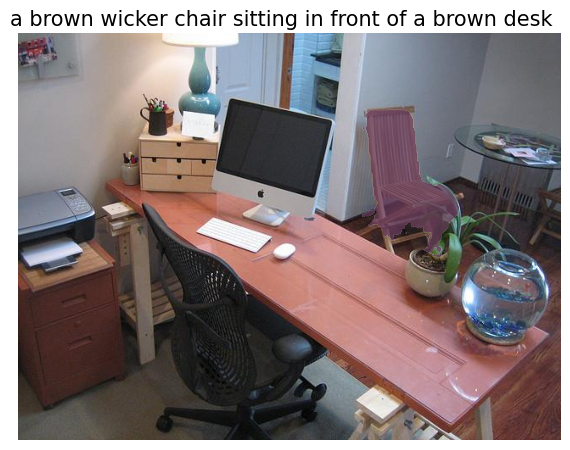

In [688]:
transform = T.Resize((224,224))
input_img = transform(resized_img.to(device))


'''
Global visual features
'''
feature_map = clip_model.encode_image(input_img)
feature_map = feature_map / feature_map.norm(dim=1, keepdim=True) # normalize feature map

masks = TF.resize(pred_masks.type(torch.float32), (feature_map.shape[2:])) # masks 들을 feature map 크기로 resize 합니다.
masked_feature_map = torch.mul(feature_map, masks[:,None,:,:]) # feature map과 masks 들을 element-wise product 합니다.

global_visual_features = clip_model.visual.attnpool(masked_feature_map)


'''
Local visual features
'''
pixel_mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1).to(device) # masked 영역을 mean으로 채웁니다.

original_img = T.Resize((height, width))(resized_img).to(device) # 이미지를 원본 크기로 변환

cropped_imgs = []

for m, b in zip(pred_masks, pred_boxes):
    m, b = m.type(torch.uint8), b.type(torch.int) # type 변환
    masked_img = original_img * m[None, None, ...] + (1 - m[None, None, ...]) * pixel_mean

    x_min, y_min, x_max, y_max = b
    h, w = y_max - y_min, x_max - x_min

    cropped_img = TF.resized_crop(masked_img.squeeze(0), y_min, x_min, h, w, (224, 224))
    cropped_imgs.append(cropped_img)

cropped_imgs = torch.stack(cropped_imgs, dim=0)

feature_map = clip_model.encode_image(cropped_imgs)
local_visual_features = clip_model.visual.attnpool(feature_map)

local_visual_features = local_visual_features / local_visual_features.norm(dim=1, keepdim=True) # normalize


'''
Global-Local visual features
'''
global_local_visual_features = 0.85 * global_visual_features + (1 - 0.85) * local_visual_features


'''
Global textual feature
'''
sentence_token = clip.tokenize(sentence).to(device) # Tokenize

sentence_feature = clip_model.encode_text(sentence_token)
sentence_feature = sentence_feature / sentence_feature.norm(dim=1, keepdim=True)


'''
Local textual feature
'''
doc = nlp(sentence)

# 문장에서 noun phrase 찾기
chunks = {i: chunk for chunk in doc.noun_chunks for i in range(chunk.start, chunk.end)}

# root word 찾기
root_word = next((token.head for token in doc if token.head.i == token.i), None)

# root word가 속해있는 noun phrase 추출
noun_phrase = chunks[head.i].text

noun_phrase_token = clip.tokenize(noun_phrase).to(device) # Tokenize
noun_phrase_feature = clip_model.encode_text(noun_phrase_token)
noun_phrase_feature = noun_phrase_feature / noun_phrase_feature.norm(dim=1, keepdim=True) # normalize


'''
Global-Local textual feature
'''
global_local_textual_feature = 0.5 * sentence_feature + (1 - 0.5) * noun_phrase_feature


'''
Mask prediction and visualization
'''
similarity = global_local_visual_features @ global_local_textual_feature.T
max_index = torch.argmax(similarity)
mask_prediction = pred_masks[max_index]


plt.figure(figsize=(7,7))
plt.imshow(image)
show_masks(mask_prediction)
plt.axis('off')
plt.text(-10, -10, sentence, fontsize=15)
plt.show() 

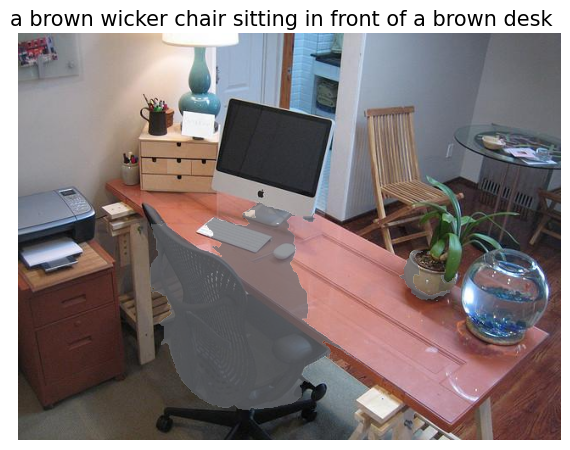

In [692]:
similarity = global_visual_features @ sentence_feature.T
max_index = torch.argmax(similarity)
mask_prediction = pred_masks[max_index]


plt.figure(figsize=(7,7))
plt.imshow(image)
show_masks(mask_prediction)
plt.axis('off')
plt.text(-10, -10, sentence, fontsize=15)
plt.show() 

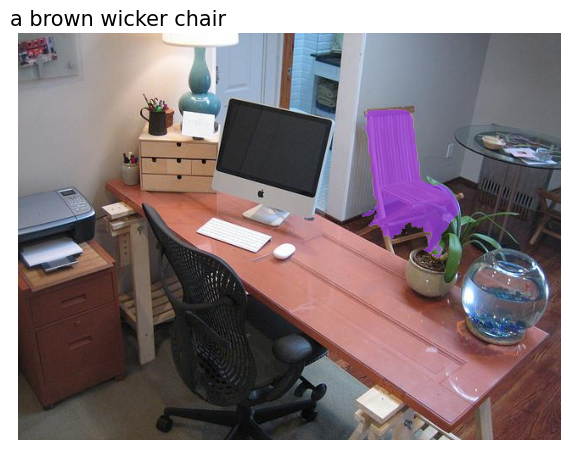

In [691]:
similarity = local_visual_features @ noun_phrase_feature.T
max_index = torch.argmax(similarity)
mask_prediction = pred_masks[max_index]


plt.figure(figsize=(7,7))
plt.imshow(image)
show_masks(mask_prediction)
plt.axis('off')
plt.text(-10, -10, noun_phrase, fontsize=15)
plt.show() 